In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import words

import sys
sys.path.append('./../../')
from models.rnn.rnn import RNN, RNNDataset
from models.ocr.ocr import OCRModel, OCRDataset

## RNN

In [2]:
def generate_bit_count_data(num_samples=100000, max_len=16):
    data, labels = [], []
    for _ in range(num_samples):
        length = np.random.randint(1, max_len + 1)
        sequence = np.random.randint(0, 2, length)
        label = np.sum(sequence)
        data.append(sequence)
        labels.append(label)
    return data, labels

In [3]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            total_loss += loss.item() * sequences.size(0)
    return total_loss / len(data_loader.dataset)

In [4]:
data, labels = generate_bit_count_data()
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data, val_data, test_data = data[:train_size], data[train_size:train_size + val_size], data[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = RNNDataset(train_data, train_labels)
val_dataset = RNNDataset(val_data, val_labels)
test_dataset = RNNDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        
        for sequences, labels, lengths in train_progress:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * sequences.size(0)
            train_progress.set_postfix(loss=loss.item())
        
        train_loss = total_train_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MAE: {train_loss:.4f}, Validation MAE: {val_loss:.4f}")


In [6]:
model = RNN(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10

In [7]:
def random_baseline_MAE(data_loader):
    loss = 0
    total = 0
    for sequences, labels, lengths in data_loader:
        for i in range(len(sequences)):
            cur_pred = np.random.randint(0, lengths[i].item() + 1)
            loss += np.abs(cur_pred - labels[i].item())
            total += 1
    return loss / total

In [8]:
print(f"Random Baseline MAE: {random_baseline_MAE(val_loader)}")

Random Baseline MAE: 2.5674


In [9]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]: 100%|██████████| 1250/1250 [00:46<00:00, 27.11it/s, loss=0.25]  


Epoch [1/10], Train MAE: 0.5564, Validation MAE: 0.3793


Epoch [2/10]: 100%|██████████| 1250/1250 [00:45<00:00, 27.61it/s, loss=0.0545]


Epoch [2/10], Train MAE: 0.1223, Validation MAE: 0.1169


Epoch [3/10]: 100%|██████████| 1250/1250 [00:44<00:00, 28.08it/s, loss=0.137] 


Epoch [3/10], Train MAE: 0.1018, Validation MAE: 0.0737


Epoch [4/10]: 100%|██████████| 1250/1250 [00:43<00:00, 28.75it/s, loss=0.0278]


Epoch [4/10], Train MAE: 0.0889, Validation MAE: 0.0613


Epoch [5/10]: 100%|██████████| 1250/1250 [00:46<00:00, 26.60it/s, loss=0.0267]


Epoch [5/10], Train MAE: 0.0887, Validation MAE: 0.0641


Epoch [6/10]: 100%|██████████| 1250/1250 [00:43<00:00, 28.58it/s, loss=0.0965]


Epoch [6/10], Train MAE: 0.0788, Validation MAE: 0.0817


Epoch [7/10]: 100%|██████████| 1250/1250 [00:43<00:00, 28.58it/s, loss=0.0363]


Epoch [7/10], Train MAE: 0.0675, Validation MAE: 0.0466


Epoch [8/10]: 100%|██████████| 1250/1250 [00:55<00:00, 22.68it/s, loss=0.0569]


Epoch [8/10], Train MAE: 0.0670, Validation MAE: 0.1191


Epoch [9/10]: 100%|██████████| 1250/1250 [00:46<00:00, 26.90it/s, loss=0.0643]


Epoch [9/10], Train MAE: 0.0703, Validation MAE: 0.0414


Epoch [10/10]: 100%|██████████| 1250/1250 [00:48<00:00, 25.98it/s, loss=0.0612]


Epoch [10/10], Train MAE: 0.0634, Validation MAE: 0.0512


In [13]:
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test MAE: {test_loss:.4f}")

Test MAE: 0.0509


In [14]:
def generate_out_of_distribution_data(start_len=1, end_len=32, samples_per_length=1000):
    data, labels = [], []
    for length in range(start_len, end_len + 1):
        for _ in range(samples_per_length):
            sequence = np.random.randint(0, 2, length)
            label = np.sum(sequence)
            data.append(sequence)
            labels.append(label)
    return data, labels

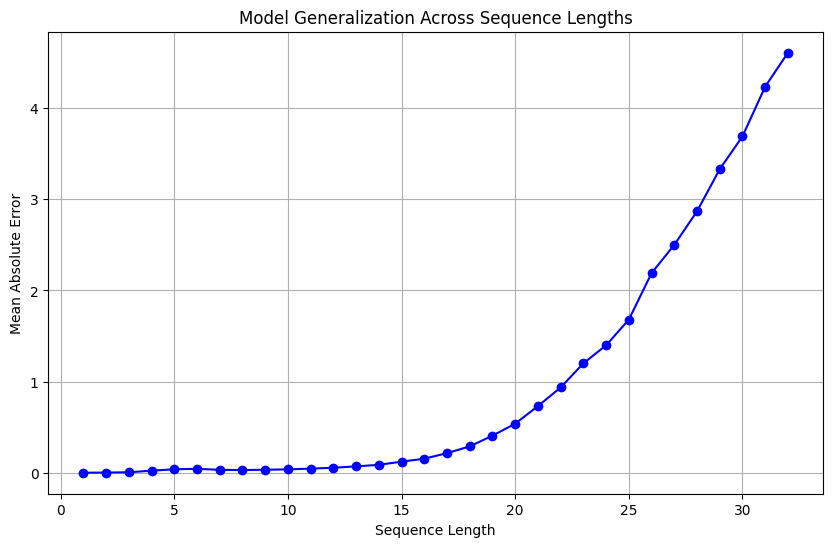

In [15]:
gen_data, gen_labels = generate_out_of_distribution_data()
lengths = list(range(1, 33))
mae_per_length = []

for length in lengths:
    length_data = []
    length_labels = []
    for seq, label in zip(gen_data, gen_labels):
        if len(seq) == length:
            length_data.append(seq)
            length_labels.append(label)
    
    length_dataset = RNNDataset(length_data, length_labels)
    length_loader = DataLoader(length_dataset, batch_size=batch_size, shuffle=False)
    mae = evaluate(model, length_loader, criterion, device)
    mae_per_length.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(lengths, mae_per_length, marker='o', color='b')
plt.title('Model Generalization Across Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.savefig('./figures/RNN_generalization.png')
plt.show()

## OCR

In [13]:
def generate_word_images(word_list, image_dir, image_size=(256, 64)):
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    for word in tqdm(word_list, desc="Generating Images"):
        img = Image.new('L', image_size, color=255)
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        font_size = 24
        font = ImageFont.truetype("arial.ttf", font_size)
        bbox = draw.textbbox((0, 0), word, font=font)
        x = (image_size[0] - (bbox[2] - bbox[0])) // 2
        y = (image_size[1] - (bbox[3] - bbox[1])) // 2
        draw.text((x, y), word, font=font, fill=0)
        img.save(os.path.join(image_dir, f"{word}.png")) 

image_dir = "./../../data/external/word_images"
# word_list = words.words()
# word_list = list(set(word_list))
# word_list = word_list[:100000]
# generate_word_images(word_list, image_dir)

In [14]:
def create_image_label_lists(image_dir):
    image_paths = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            if ('-' in filename) or ('_' in filename):
                continue
            label = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_dir, filename))
            labels.append(label)
    return image_paths, labels

In [15]:
image_paths, labels = create_image_label_lists(image_dir)
max_word_length = max(len(label) for label in labels)
print(f"Max Word Length: {max_word_length}")

image_paths_temp, labels_temp = np.array(image_paths), np.array(labels)
idx = np.random.permutation(len(image_paths_temp))
image_paths, labels = image_paths_temp[idx].tolist(), labels_temp[idx].tolist()

train_size = int(0.8 * len(image_paths))
val_size = int(0.1 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size + val_size], image_paths[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = OCRDataset(train_paths, train_labels, max_length=max_word_length)
val_dataset = OCRDataset(val_paths, val_labels, max_length=max_word_length)
test_dataset = OCRDataset(test_paths, test_labels, max_length=max_word_length)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Max Word Length: 24


In [16]:
def decode_label(one_hot_encoded):
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    decoded = ""
    for i in range(one_hot_encoded.shape[0]):
        idx = torch.argmax(one_hot_encoded[i]).item()
        if idx == 0:
            break
        decoded += char_map[idx]
    return decoded

In [17]:
def get_weights():
    weigths = torch.ones(53, dtype=torch.float)
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    weigths[0] = 0.2
    return weigths

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel(num_classes=53, max_length=max_word_length).to(device)
weigth = get_weights(train_labels).to(device)
criterion = nn.CrossEntropyLoss(weight=weigth)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
def evaluate(model, data_loader, criterion, device, print_output=False):
    model.eval()
    total_loss = 0
    correct_chars = 0
    total_chars = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            for i in range(len(labels)):
                predicted_label = decode_label(outputs[i])
                true_label = decode_label(labels[i])
                if print_output and i==0:
                    print(true_label, "<-- True Label")
                    print(predicted_label, "<-- Predicted Label")
                for j in range(len(true_label)):
                    if j < len(predicted_label) and predicted_label[j] == true_label[j]:
                        correct_chars += 1
                    total_chars += 1
    avg_correct_chars = correct_chars / total_chars
    total_loss = total_loss / len(data_loader)
    return total_loss, avg_correct_chars

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
        
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, avg_correct_chars = evaluate(model, val_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ANCC in Val: {avg_correct_chars:.4f}")

In [21]:
def random_baseline_accuracy(labels):
    correct_chars = 0
    total_chars = 0
    for label in labels:
        predicted_label = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'), len(label)))
        for i in range(len(label)):
            if predicted_label[i] == label[i]:
                correct_chars += 1
            total_chars += 1
    return correct_chars / total_chars

In [22]:
random_accuracy = random_baseline_accuracy(val_labels)
print(f"Random Baseline Accuracy: {random_accuracy:.4f}")

Random Baseline Accuracy: 0.0189


In [23]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10] - Training: 100%|██████████| 1247/1247 [02:42<00:00,  7.65it/s]


Epoch [1/10], Train Loss: 1.0687, Val Loss: 0.7889, ANCC in Val: 0.3752


Epoch [2/10] - Training: 100%|██████████| 1247/1247 [02:40<00:00,  7.75it/s]


Epoch [2/10], Train Loss: 0.5794, Val Loss: 0.3493, ANCC in Val: 0.7155


Epoch [3/10] - Training: 100%|██████████| 1247/1247 [02:31<00:00,  8.24it/s]


Epoch [3/10], Train Loss: 0.2827, Val Loss: 0.1693, ANCC in Val: 0.8666


Epoch [4/10] - Training: 100%|██████████| 1247/1247 [02:25<00:00,  8.58it/s]


Epoch [4/10], Train Loss: 0.1661, Val Loss: 0.1172, ANCC in Val: 0.9081


Epoch [5/10] - Training: 100%|██████████| 1247/1247 [02:13<00:00,  9.33it/s]


Epoch [5/10], Train Loss: 0.1176, Val Loss: 0.0841, ANCC in Val: 0.9336


Epoch [6/10] - Training: 100%|██████████| 1247/1247 [02:13<00:00,  9.34it/s]


Epoch [6/10], Train Loss: 0.0946, Val Loss: 0.0651, ANCC in Val: 0.9491


Epoch [7/10] - Training: 100%|██████████| 1247/1247 [02:16<00:00,  9.10it/s]


Epoch [7/10], Train Loss: 0.0822, Val Loss: 0.0567, ANCC in Val: 0.9560


Epoch [8/10] - Training: 100%|██████████| 1247/1247 [02:16<00:00,  9.13it/s]


Epoch [8/10], Train Loss: 0.0693, Val Loss: 0.0469, ANCC in Val: 0.9647


Epoch [9/10] - Training: 100%|██████████| 1247/1247 [02:35<00:00,  8.04it/s]


Epoch [9/10], Train Loss: 0.0642, Val Loss: 0.0564, ANCC in Val: 0.9574


Epoch [10/10] - Training: 100%|██████████| 1247/1247 [02:13<00:00,  9.32it/s]


Epoch [10/10], Train Loss: 0.0566, Val Loss: 0.0508, ANCC in Val: 0.9612


In [24]:
test_loss, avg_correct_chars = evaluate(model, test_loader, criterion, device, print_output=True)
print(f"Test Loss: {test_loss:.4f}, ANCC in Test: {avg_correct_chars:.4f}")

murkly <-- True Label
murkly <-- Predicted Label
spinigrade <-- True Label
spinigrade <-- Predicted Label
overmercifulness <-- True Label
overmercifuiness <-- Predicted Label
armload <-- True Label
armload <-- Predicted Label
intrahepatic <-- True Label
intrahepatic <-- Predicted Label
irresilient <-- True Label
irresilient <-- Predicted Label
thunderblast <-- True Label
thunderblast <-- Predicted Label
manuscription <-- True Label
manuscription <-- Predicted Label
stockjobber <-- True Label
scockiobber <-- Predicted Label
reactionism <-- True Label
reactionism <-- Predicted Label
dichastic <-- True Label
dichastic <-- Predicted Label
commonplacely <-- True Label
commonplacely <-- Predicted Label
plague <-- True Label
plague <-- Predicted Label
contraoctave <-- True Label
contraoctane <-- Predicted Label
killcu <-- True Label
killcul <-- Predicted Label
overcontentment <-- True Label
overcontentment <-- Predicted Label
trimeter <-- True Label
trimeter <-- Predicted Label
astrometeorolo